In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import pandas as pd
import scipy
from scipy.optimize import minimize
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress
import statsmodels.api as sm

In [3]:
iid_equal = pd.read_csv('all_subject_equal.csv',sep ="\t", header=0)
iid_n_equal = pd.read_csv('all_subject_n_equal.csv',sep ="\t", header=0)
iid_opp = pd.read_csv('C:/Users/Oleg/Desktop/Paris Saclay/These/4_DATA/data_exp_1/path_check/info_iid_opposite_28s.csv',sep =";", header=0)
iid_same = pd.read_csv('C:/Users/Oleg/Desktop/Paris Saclay/These/4_DATA/data_exp_1/path_check/info_iid_same_28s.csv',sep =";", header=0)

In [4]:
# Выбираем строки из iid_equal, где 'index_old' равен 21
rows_to_replace = iid_equal[iid_equal['index_old'] == 21]

# Выбираем строки из iid_n_equal, где 'index_old' равен 22
replacement_rows = iid_n_equal[(iid_n_equal['index_old'] == 22) & (iid_n_equal['path'] == '15%')]
replacement_rows[['mean_val','mean_last5','mean_last15','last_visibl_center_dist[deg]']] = abs(replacement_rows[['mean_val','mean_last5','mean_last15','last_visibl_center_dist[deg]']])

# Убираем столбцы, которые не нужно изменять
columns_to_exclude = ['# subj', 'trial', 'index_traj', 'path', 'last_cond', 'condition', 'mean_side','last_visibl_side',
                      'response', 'RT', 'prop_last_5', 'prop_last_15', 'prop_ms', 
                      'prop_lv', 'accuracy']


for column in iid_equal.columns:
    if column not in columns_to_exclude:
        iid_equal.loc[rows_to_replace.index, column] = replacement_rows[column].values
new_rows = iid_equal[(iid_equal['index_old'] == 22) & (iid_equal['path'] == '15%') & (iid_equal['mean_side'] == 'left')]
for column in ['mean_val', 'mean_last5', 'mean_last15']:
    iid_equal.loc[new_rows.index, column] *= -1

C:\Users\Oleg\AppData\Local\Temp\ipykernel_13948\3265148335.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  replacement_rows[['mean_val','mean_last5','mean_last15','last_visibl_center_dist[deg]']] = abs(replacement_rows[['mean_val','mean_last5','mean_last15','last_visibl_center_dist[deg]']])


In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
def create_intervals(min_value, max_value, mean_value):
    # Small interval
    small_interval = [min_value, round(mean_value - (mean_value - min_value) / 2,3)]
    # Mean interval
    mean_interval = [round(mean_value - (mean_value - min_value) / 2,3), round(mean_value + (max_value - mean_value) / 2,3)]
    # Big interval
    big_interval = [round(mean_value + (max_value - mean_value) / 2,3), max_value]
    return small_interval, mean_interval, big_interval

In [6]:
def path_responces (path):
    grouped_data = path.groupby(['index_traj', 'condition', 'mean_side']).agg(
    path=pd.NamedAgg(column='path', aggfunc='first'),
    last_cond=pd.NamedAgg(column='last_cond', aggfunc='first'),
    index_old=pd.NamedAgg(column='index_old', aggfunc='first'),
    mean_val=pd.NamedAgg(column='mean_val', aggfunc='first'),
    mean_last5=pd.NamedAgg(column='mean_last5', aggfunc='first'),
    mean_last15=pd.NamedAgg(column='mean_last15', aggfunc='first'),
    sd=pd.NamedAgg(column='sd', aggfunc='first'),
    last_visibl_side=pd.NamedAgg(column='last_visibl_side', aggfunc='first'),
    f_missing_pos=pd.NamedAgg(column='f_missing_pos', aggfunc='first'),
    last_visibl_center_dist_deg=pd.NamedAgg(column='last_visibl_center_dist[deg]', aggfunc='first'),
    correct=pd.NamedAgg(column='accuracy', aggfunc=lambda x: (x == 1).sum()),
    error=pd.NamedAgg(column='accuracy', aggfunc=lambda x: (x == 0).sum()),
    acc=pd.NamedAgg(column='accuracy', aggfunc=lambda x: np.round(x.mean(), 3)),
    RT=pd.NamedAgg(column='RT', aggfunc=lambda x: np.round(x.mean(), 3))).reset_index()
    grouped_data['mean_abs'] = grouped_data['mean_val'].apply(abs)
    group_sd = []
    for sd in grouped_data['sd']:
        if sd < 3.4:
            group_sd.append(1)
        elif 3.4 <= sd < 5.3:
            group_sd.append(2)
        else:  # Assuming sd >= 5.5
            group_sd.append(3)
    grouped_data['group_sd'] = group_sd
    grouped_data['mean/std'] = round( abs(abs(grouped_data['mean_val'])/ grouped_data['sd']),3)
    # Calculating the difference between mean_abs and JND for each group
    diff_list = []
    # jnd_values = {1: 0.386, 2: 0.581, 3: 0.654}
    # jnd_values = {1: 1.3, 2: 1.3, 3: 1.3}
    jnd_values = {1: 0.6, 2: 0.9, 3: 1.3}
    for i in range(grouped_data.shape[0]):
        group = grouped_data['group_sd'][i]
        jnd = jnd_values[group]
    #     diff = round(abs(grouped_data['mean_abs'][i] - jnd), 3)
        diff = round(grouped_data['mean_abs'][i] - jnd, 3)
        diff_list.append(diff)

    grouped_data['mu-jnd'] = diff_list

    return grouped_data
    

In [7]:
def path_responces_exp1 (path_info):
    
    path_info = path_info.drop(['ok', "more corr answ", "mean=last10"], axis = 1)
    path_info['mean/std'] = round(abs(abs(path_info['Mean'])/ path_info['Standard Deviation']),3)
    path_info['acc'] = path_info['correct'].apply(lambda x: np.round( x/28,3) )
    group_sd = []
    intervals_sd = create_intervals(path_info['Standard Deviation'].min(), path_info['Standard Deviation'].max(), 
                                    path_info['Standard Deviation'].mean())
    print(intervals_sd)
    for i in range(path_info.shape[0]):
        if path_info['Standard Deviation'][i] < 3.3:
            group_sd.append(1)
        if 3.3<= path_info['Standard Deviation'][i] < 5.5:
            group_sd.append(2) 
    #     if 4.42 <= df['sd'][i] < 5.7:
    #         group_sd.append(3)     
        if path_info['Standard Deviation'][i] >=5.5:
            group_sd.append(3)  
    path_info["group_sd"] = group_sd
    
    diff_list = []

    jnd_values = {1: 0.62, 2: 0.89, 3: 1.27}
    # jnd_values = {1: 1.34, 2: 1.30, 3: 2.26}
    for i in range(path_info.shape[0]):
        group = path_info['group_sd'][i]
        jnd = jnd_values[group]
    #     diff = round(abs(iid_opposite_data['mean_abs'][i] - jnd), 3)
        diff = round(abs(path_info['Mean'][i]) - jnd, 3)
        diff_list.append(diff)

    path_info['mu-jnd'] = diff_list
    return path_info

In [8]:
iid_same = path_responces_exp1(iid_same)
iid_opp = path_responces_exp1(iid_opp)

iid_n_equal = path_responces(iid_n_equal)
iid_equal = path_responces(iid_equal)

([2.097, 3.241], [3.241, 5.669], [5.669, 6.953])
([2.128, 3.305], [3.305, 5.507], [5.507, 6.532])


In [9]:
iid_opp[['acc','mu-jnd']]

,acc,mu-jnd
0,0.857,1.591
1,0.429,0.155
2,0.857,0.847
3,0.750,0.314
4,0.857,0.467
...,...,...
95,0.500,0.584
96,0.750,0.682
97,0.357,0.037
98,0.750,-0.382


In [10]:
import statsmodels.api as sm

X = iid_opp['mu-jnd']  
y = iid_opp['acc']  
X = sm.add_constant(X)  

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    acc   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     16.01
Date:                Sat, 18 May 2024   Prob (F-statistic):           0.000122
Time:                        20:51:34   Log-Likelihood:                 52.590
No. Observations:                 100   AIC:                            -101.2
Df Residuals:                      98   BIC:                            -95.97
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6148      0.020     30.385      0.0

Exp 1 analysys

In [11]:
models = []
X = iid_same['mu-jnd']
y = iid_same['acc'] 
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()  
models.append(( model))  
print(f'iid_same {model.summary()}')

X = iid_opp['mu-jnd']
y = iid_opp['acc'] 
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()  
models.append(( model))  
print(f'iid_opposite {model.summary()}')

iid_same                             OLS Regression Results                            
Dep. Variable:                    acc   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     18.05
Date:                Sat, 18 May 2024   Prob (F-statistic):           4.91e-05
Time:                        20:54:48   Log-Likelihood:                 53.794
No. Observations:                 100   AIC:                            -103.6
Df Residuals:                      98   BIC:                            -98.38
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6512      0.033     19.565

In [12]:
slope, intercept, r_value, p_value, std_err = linregress(iid_same['mu-jnd'], iid_same['acc'])
print(f"IID same: slope = {round(slope,3)}, intercept = {round(intercept,3)}, r_value = {round(r_value,3)}, p_value = {round(p_value,3)}, std_err = {round(std_err,3)}")
slope, intercept, r_value, p_value, std_err = linregress(iid_opp['mu-jnd'], iid_opp['acc'])
print(f"IID opp: slope = {round(slope,3)}, intercept = {round(intercept,3)}, r_value = {round(r_value,3)}, p_value = {round(p_value,3)}, std_err = {round(std_err,3)}")

IID same: slope = 0.122, intercept = 0.651, r_value = 0.394, p_value = 0.0, std_err = 0.029
IID opp: slope = 0.114, intercept = 0.615, r_value = 0.375, p_value = 0.0, std_err = 0.029


In [13]:
commun_index = set(iid_equal['index_old'])

In [14]:
iid_opp_sub = iid_opp[iid_opp['index path 2'].isin(commun_index)].reset_index(drop=True)
iid_same_sub = iid_same[iid_same['index path 2'].isin(commun_index)].reset_index(drop=True)
iid_opp_sub

,inex path,index path 2,path,cond,mean_cond,Mean,Mean_last15,Mean_last10,Mean_last5,Standard Deviation,...,Count 0 (right resp),Count 1 (left resp),correct,error,mean=last15,mean=last5,mean/std,acc,group_sd,mu-jnd
0,1,1,iid,opposite,left,-0.775,0.450,1.340,1.368,2.342,...,16.0,12.0,12.0,16.0,n,n,0.331,0.429,1,0.155
1,6,6,iid,opposite,left,-0.931,-0.170,-0.720,1.268,2.989,...,15.0,13.0,13.0,15.0,y,n,0.311,0.464,1,0.311
2,9,9,iid,opposite,left,-1.166,-0.943,-0.469,-0.080,2.524,...,9.0,19.0,19.0,9.0,y,y,0.462,0.679,1,0.546
3,11,11,iid,opposite,left,-0.946,-0.794,0.784,0.493,3.877,...,19.0,9.0,9.0,19.0,y,n,0.244,0.321,2,0.056
4,17,17,iid,opposite,left,-0.985,-0.359,-1.339,-1.015,3.711,...,11.0,17.0,17.0,11.0,y,y,0.265,0.607,2,0.095
5,18,18,iid,opposite,left,-1.031,-0.310,-0.269,0.585,3.254,...,14.0,14.0,14.0,14.0,y,n,0.317,0.500,1,0.411
6,22,22,iid,opposite,left,-1.244,-2.345,-2.790,1.514,4.911,...,16.0,12.0,12.0,16.0,y,n,0.253,0.429,2,0.354
7,25,25,iid,opposite,left,-0.942,-0.634,0.126,1.682,4.765,...,12.0,16.0,16.0,12.0,y,n,0.198,0.571,2,0.052
8,26,26,iid,opposite,left,-1.733,-0.220,0.220,-2.369,4.764,...,11.0,17.0,17.0,11.0,y,y,0.364,0.607,2,0.843
9,27,27,iid,opposite,left,-1.171,-0.735,0.358,1.480,4.454,...,11.0,17.0,17.0,11.0,y,n,0.263,0.607,2,0.281


In [ ]:

iid_same_sub

In [ ]:
# Scatter plot with regression line
sns.lmplot(x='mean/std', y='acc', data=iid_n_equal, ci=None, scatter_kws={'alpha':0.5})
plt.title('IID NOT EQUAL: mu/sd vs acc')
plt.xlabel('mean/std')
plt.ylabel('acc ')
plt.show()

slope, intercept, r_value, p_value, std_err = linregress(iid_n_equal['mean/std'], iid_n_equal['acc'])
print(f"IID EQUAL: slope = {round(slope,3)}, intercept = {round(intercept,3)}, r_value = {round(r_value,3)}, p_value = {round(p_value,3)}, std_err = {round(std_err,3)}")

sns.lmplot(x='mean/std', y='acc', data=iid_opp_sub, ci=None, scatter_kws={'alpha':0.5})
plt.title('IID opposite: mean/std vs acc')
plt.xlabel('mean/std')
plt.ylabel('acc ')
plt.show()

slope, intercept, r_value, p_value, std_err = linregress(iid_opp_sub['mean/std'], iid_opp_sub['acc'])
print(f"IID NOT EQUAL: slope = {round(slope,3)}, intercept = {round(intercept,3)}, r_v = {round(r_value,3)}, p_v = {round(p_value,3)}, std_err = {round(std_err,3)}")

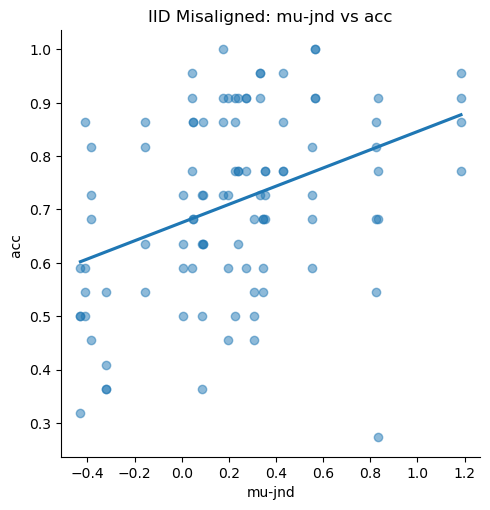

IID NOT EQUAL: slope = 0.17, intercept = 0.675, r_value = 0.384, p_value = 0.0, std_err = 0.041


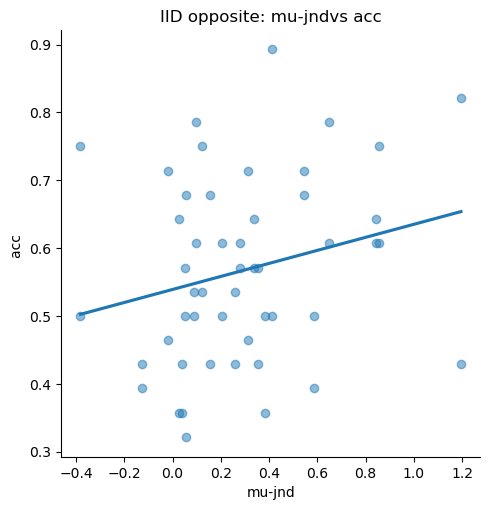

iid_opp_sub: slope = 0.096, intercept = 0.539, r_v = 0.239, p_v = 0.094, std_err = 0.056


In [15]:
# Scatter plot with regression line
sns.lmplot(x='mu-jnd', y='acc', data=iid_n_equal, ci=None, scatter_kws={'alpha':0.5})
plt.title('IID Misaligned: mu-jnd vs acc')
plt.xlabel('mu-jnd')
plt.ylabel('acc ')
plt.show()

slope, intercept, r_value, p_value, std_err = linregress(iid_n_equal['mu-jnd'], iid_n_equal['acc'])
print(f"IID NOT EQUAL: slope = {round(slope,3)}, intercept = {round(intercept,3)}, r_value = {round(r_value,3)}, p_value = {round(p_value,3)}, std_err = {round(std_err,3)}")

sns.lmplot(x='mu-jnd', y='acc', data=iid_opp_sub, ci=None, scatter_kws={'alpha':0.5})
plt.title('IID opposite: mu-jndvs acc')
plt.xlabel('mu-jnd')
plt.ylabel('acc ')
plt.show()

slope, intercept, r_value, p_value, std_err = linregress(iid_opp_sub['mu-jnd'], iid_opp_sub['acc'])
print(f"iid_opp_sub: slope = {round(slope,3)}, intercept = {round(intercept,3)}, r_v = {round(r_value,3)}, p_v = {round(p_value,3)}, std_err = {round(std_err,3)}")

In [ ]:
# Scatter plot with regression line
sns.lmplot(x='mu-jnd', y='acc', data=iid_opp, ci=None, scatter_kws={'alpha':0.5})
plt.title('LR iid opposite: mu-jnd vs acc')
plt.xlabel('mu-jnd difference')
plt.ylabel('correct resp')
# plt.xlim(0,2)
plt.show()

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(iid_opp['mu-jnd'], iid_opp['acc'])
print(f" Slope = {round(slope,3)}, Intercept = {round(intercept,3)}, R-value = {round(r_value,3)}, P-value = {round(p_value,3)}, Std_err = {round(std_err,3)}")


In [ ]:
# Сравнение точности ответов между iid_opp_sub и iid_n_equal
accuracy_iid_opp_sub = iid_opp_sub['acc'].mean()
accuracy_iid_n_equal = iid_n_equal['acc'].mean()

accuracy_iid_opp_sub,accuracy_iid_n_equal 


In [ ]:
# acc just for similar path and similar condition

filtered_iid_opp_sub = iid_opp_sub[iid_opp_sub['mean=last5'] == 'n']


filtered_iid_n_equal = iid_n_equal[iid_n_equal['path'] == '5%']
filtered_iid_n_equal = filtered_iid_n_equal[filtered_iid_n_equal['index_old'].isin(filtered_iid_opp_sub['index path 2'])]

accuracy_filtered_iid_n_equal = filtered_iid_n_equal['acc'].mean()
accuracy_filtered_iid_opp_sub = filtered_iid_opp_sub['acc'].mean()
accuracy_filtered_iid_n_equal,accuracy_filtered_iid_opp_sub

In [ ]:
from scipy.stats import ttest_ind

t_statistic, p_value = ttest_ind(filtered_iid_n_equal['acc'], filtered_iid_opp_sub['acc'])
t_statistic, p_value

In [ ]:
models = []
X = filtered_iid_opp_sub['mu-jnd']
y = filtered_iid_opp_sub['acc'] 
model = sm.OLS(y, X).fit()  
models.append(( model))  
print(f'iid_opp {model.summary()}')

X = filtered_iid_n_equal['mu-jnd']
y = filtered_iid_n_equal['acc'] 
model = sm.OLS(y, X).fit()  
models.append(( model))  
print(f'iid_equal 5% {model.summary()}')

In [ ]:
filtered_iid_opp_sub = iid_opp_sub[iid_opp_sub['mean=last5'] == 'n']


filtered_iid_n_equal = iid_n_equal[iid_n_equal['path'] == '15%']
filtered_iid_n_equal = filtered_iid_n_equal[filtered_iid_n_equal['index_old'].isin(filtered_iid_opp_sub['index path 2'])]

accuracy_filtered_iid_n_equal = filtered_iid_n_equal['acc'].mean()
accuracy_filtered_iid_opp_sub = filtered_iid_opp_sub['acc'].mean()
accuracy_filtered_iid_n_equal,accuracy_filtered_iid_opp_sub

In [ ]:
from scipy.stats import ttest_ind

t_statistic, p_value = ttest_ind(filtered_iid_n_equal['acc'], filtered_iid_opp_sub['acc'])
t_statistic, p_value

In [ ]:
# filtered_iid_opp_sub_y = iid_opp_sub[iid_opp_sub['mean=last5'] == 'y']

# filtered_iid_n_equal_y = iid_n_equal[iid_n_equal['path'] == '5%']
# filtered_iid_n_equal_y = filtered_iid_n_equal_y[filtered_iid_n_equal_y['index_old'].isin(filtered_iid_opp_sub_y['index path 2'])]

# accuracy_filtered_iid_n_equal_y = filtered_iid_n_equal_y['acc'].mean()
# accuracy_filtered_iid_opp_sub_y = filtered_iid_opp_sub_y['acc'].mean()

# accuracy_filtered_iid_n_equal_y, accuracy_filtered_iid_opp_sub_y


In [ ]:
filtered_iid_opp_sub_y = iid_opp_sub[iid_opp_sub['mean=last5'] == 'y']

filtered_iid_equal = iid_equal[iid_equal['path'] == '5%']
filtered_iid_equal = filtered_iid_equal[filtered_iid_equal['index_old'].isin(filtered_iid_opp_sub_y['index path 2'])]

accuracy_filtered_iid_equal = filtered_iid_equal['acc'].mean()
accuracy_filtered_iid_opp_sub_y = filtered_iid_opp_sub['acc'].mean()

accuracy_filtered_iid_equal, accuracy_filtered_iid_opp_sub_y

In [ ]:
from scipy.stats import ttest_ind

t_statistic, p_value = ttest_ind(filtered_iid_equal['acc'], filtered_iid_opp_sub_y['acc'])
t_statistic, p_value